In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import shap

In [ ]:
# Load data
df = pd.read_csv('/content/all_cases_w_clusters.csv') \
      .loc[:, ['Reflectivity','Zdr','Kdp','Rhohv','gauge_precipitation_matched']] \
      .dropna()

df.head()

,Reflectivity,Zdr,Kdp,Rhohv,gauge_precipitation_matched
0,32.035745,0.002344,0.038146,1.002583,1.016
1,32.077695,-0.018490,0.042459,1.000917,1.270
2,17.183210,-0.028255,-0.010754,1.000500,0.508
3,16.943034,0.042578,-0.002402,0.998278,0.508
4,16.657248,0.015625,0.022643,0.996319,0.508


In [ ]:
df.shape

(2677, 5)

In [ ]:
df.isnull().sum()

,0
Reflectivity,0
Zdr,0
Kdp,0
Rhohv,0
gauge_precipitation_matched,0


## SR based Symbolic model

In [ ]:
class SymbolicModel(nn.Module):
    def __init__(self):
        super(SymbolicModel, self).__init__()
        self.a = nn.Parameter(torch.tensor([0.850], dtype=torch.float32))
        self.b = nn.Parameter(torch.tensor([0.482], dtype=torch.float32))
        self.c = nn.Parameter(torch.tensor([10.925], dtype=torch.float32))

    def forward(self, Zdr, Kdp, Z):
        intermediate_result = (self.a ** Zdr) * Z * (Kdp + self.b) - self.c
        if torch.isnan(intermediate_result).any():
            intermediate_result = torch.nan_to_num(intermediate_result, nan=0.0)
        return torch.abs(intermediate_result)

# Or

## Empirical based symbolic model

In [ ]:
class SymbolicModel(nn.Module):
    def __init__(self):
        super(SymbolicModel, self).__init__()

        self.a_zh = nn.Parameter(torch.tensor(0.0170, dtype=torch.float32))
        self.b_zh = nn.Parameter(torch.tensor(0.7143, dtype=torch.float32))

        self.a_kdp = nn.Parameter(torch.tensor(40.5, dtype=torch.float32))
        self.b_kdp = nn.Parameter(torch.tensor(0.85, dtype=torch.float32))

        self.a_zh_zdr = nn.Parameter(torch.tensor(0.0067, dtype=torch.float32))
        self.b_zh_zdr = nn.Parameter(torch.tensor(0.927, dtype=torch.float32))
        self.c_zh_zdr = nn.Parameter(torch.tensor(-0.343, dtype=torch.float32))

        self.a_kdp_zdr = nn.Parameter(torch.tensor(90.8, dtype=torch.float32))
        self.b_kdp_zdr = nn.Parameter(torch.tensor(0.93, dtype=torch.float32))
        self.c_kdp_zdr = nn.Parameter(torch.tensor(-0.169, dtype=torch.float32))

    def forward(self, ZDR, KDP, ZH):
        output = self.calculate_output(ZDR, KDP, ZH)
        output = torch.nan_to_num(output, nan=0.0)
        return output

    def calculate_output(self, ZDR, KDP, ZH):
        cond1 = (KDP >= 0.3) & (ZH >= 38)
        cond2 = (KDP < 0.3)

        output = torch.zeros_like(ZH)

        # Apply R(KDP, ZDR) or R(KDP) based on ZDR
        output[cond1 & (ZDR >= 0.5)] = self.R_KDP_ZDR(KDP[cond1 & (ZDR >= 0.5)], ZDR[cond1 & (ZDR >= 0.5)])
        output[cond1 & (ZDR < 0.5)] = self.R_KDP(KDP[cond1 & (ZDR < 0.5)])

        # Apply R(ZH, ZDR) or R(ZH) based on ZDR
        output[cond2 & (ZDR >= 0.5)] = self.R_ZH_ZDR(ZH[cond2 & (ZDR >= 0.5)], ZDR[cond2 & (ZDR >= 0.5)])
        output[cond2 & (ZDR < 0.5)] = self.R_ZH(ZH[cond2 & (ZDR < 0.5)])

        return output

    def R_ZH(self, ZH):
        return self.a_zh * torch.pow(ZH, self.b_zh)

    def R_KDP(self, KDP):
        return self.a_kdp * torch.pow(KDP, self.b_kdp)

    def R_ZH_ZDR(self, ZH, ZDR):

        return self.a_zh_zdr * ZH.pow(self.b_zh_zdr) * torch.pow(10, self.c_zh_zdr * ZDR)

    def R_KDP_ZDR(self, KDP, ZDR):
        return self.a_kdp_zdr * torch.pow(KDP, self.b_kdp_zdr) * torch.pow(10, self.c_kdp_zdr * ZDR)


In [ ]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 64)  # 4 inputs for Reflectivity, Zdr, Kdp, Rhohv
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Output a single value: precipitation rate (gauge_precipitation_matched)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class NeuroSymbolicModel(nn.Module):
    def __init__(self):
        super(NeuroSymbolicModel, self).__init__()
        self.neural_net = SimpleNeuralNetwork()
        self.symbolic_net = SymbolicModel()

    def forward(self, x):
        # Predict using the neural network component
        neural_pred = self.neural_net(x)

        # Predict using the symbolic component
        symbolic_pred = self.symbolic_net(x[:, 1], x[:, 2], x[:, 0])

        return neural_pred, symbolic_pred


In [ ]:
# Combining Losses
def custom_loss_and_combine(neural_pred, symbolic_pred, target, should_print=True, neural_weight=2):
    criterion = nn.MSELoss()

    # Calculate individual losses
    loss_symbolic = criterion(symbolic_pred, target)
    loss_neural = criterion(neural_pred, target)


    # Apply the maximum neural network weight threshold
    if neural_weight != 2:
        Wd = neural_weight
        Ws = 1 - Wd
        Ws = torch.tensor(Ws, dtype=torch.float32)
        Wd = torch.tensor(Wd, dtype=torch.float32)

    elif neural_weight == 2:
        # Calculate weights inversely proportional to losses
      Ws = 1 / loss_symbolic
      Wd = 1 / loss_neural
      Wsum = Ws + Wd
      Ws = Ws / Wsum
      Wd = Wd / Wsum

    ### Print weights
    if should_print:
      print(f"Weights for Combined Loss - Symbolic: {Ws}, Neural: {Wd}")

    # Calculate combined prediction
    R_combined = Ws * symbolic_pred + Wd * neural_pred

    # Combined loss for backpropagation (could use either as the main loss or a combination)
    combined_loss = Ws * loss_symbolic + Wd * loss_neural

    return combined_loss, loss_symbolic, loss_neural, R_combined, Ws, Wd

In [ ]:
# Praparing data

features = df[['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']]
target = df['gauge_precipitation_matched']


In [ ]:
## Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)


In [ ]:
# Convert to Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Training

### for Dynamic weighting : neural_weight= 2
### for Static weighting : neural_weight != 2  

In [ ]:
model = NeuroSymbolicModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 700
losses = []
symbolic_losses = []
neural_losses = []
weights_storage = {'symbolic': [], 'neural': []}

neural_weight = 2

# Training loop
for epoch in range(epochs):
    # unfreeze_symbolic_parameters(epoch)
    optimizer.zero_grad()

    # Forward pass to get predictions
    neural_pred, symbolic_pred = model(X_train_tensor)

    should_print = (epoch % 10 == 0)

    # Calculate custom loss and get combined predictions
    loss, loss_symbolic, loss_neural, combined_pred, Ws, Wd = custom_loss_and_combine(neural_pred.squeeze(), symbolic_pred, y_train_tensor, should_print, neural_weight = neural_weight)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses for plotting
    losses.append(loss.item())
    symbolic_losses.append(loss_symbolic.item())
    neural_losses.append(loss_neural.item())

    # Store weights
    weights_storage['symbolic'].append(Ws.item())
    weights_storage['neural'].append(Wd.item())

    if epoch % 100 == 0:
        print(symbolic_pred.isnan().sum())
        print(f"Epoch {epoch}, Combined Loss: {loss.item()}, Symbolic Loss: {loss_symbolic.item()}, Neural Loss: {loss_neural.item()}")


In [ ]:
weights_storage['symbolic'][-1], weights_storage['neural'][-1]

(0.2592407464981079, 0.7407591938972473)

### Printing callibrated weights

In [ ]:

print("Learned parameters of the Symbolic Model:")
print(f"a_zh: {model.symbolic_net.a_zh.item()}")
print(f"b_zh: {model.symbolic_net.b_zh.item()}")

print(f"a_kdp: {model.symbolic_net.a_kdp.item()}")
print(f"b_kdp: {model.symbolic_net.b_kdp.item()}")

print(f"a_zh_zdr: {model.symbolic_net.a_zh_zdr.item()}")
print(f"b_zh_zdr: {model.symbolic_net.b_zh_zdr.item()}")
print(f"c_zh_zdr: {model.symbolic_net.c_zh_zdr.item()}")

print(f"a_kdp_zdr: {model.symbolic_net.a_kdp_zdr.item()}")
print(f"b_kdp_zdr: {model.symbolic_net.b_kdp_zdr.item()}")
print(f"c_kdp_zdr: {model.symbolic_net.c_kdp_zdr.item()}")


Learned parameters of the Symbolic Model:
a_zh: nan
b_zh: nan
a_kdp: 40.86505126953125
b_kdp: 0.5780478715896606
a_zh_zdr: 0.1513487547636032
b_zh_zdr: 1.188355803489685
c_zh_zdr: -0.24500496685504913
a_kdp_zdr: 90.6391830444336
b_kdp_zdr: 0.9677543044090271
c_kdp_zdr: -0.24748767912387848


In [ ]:
# Save the model
torch.save(model.state_dict(), 'neuro_symbolic_model.pth')

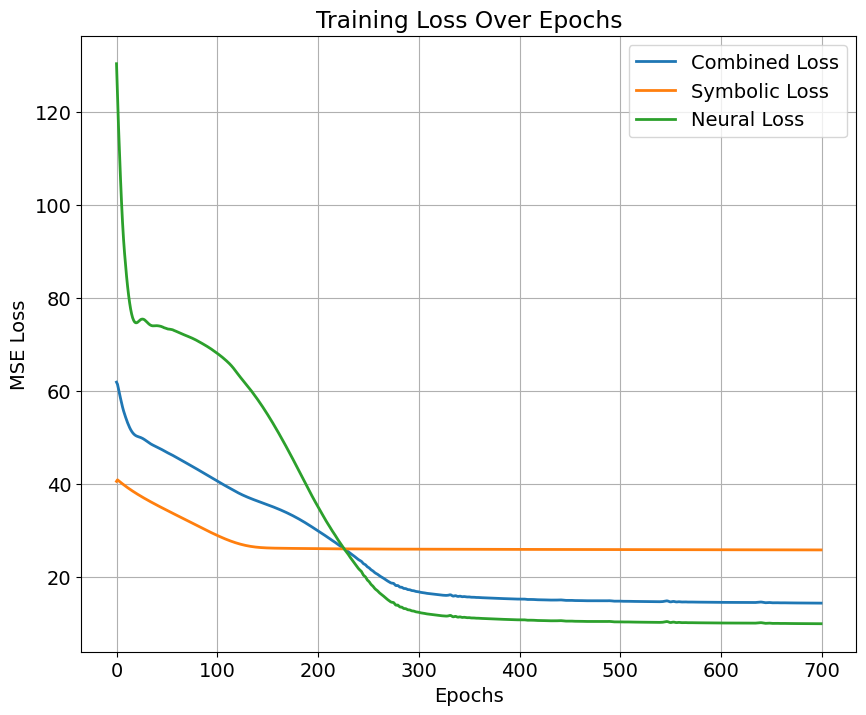

In [ ]:
# Plotting the results

plt.rcParams.update({'font.size': 14, 'lines.linewidth': 2})

plt.figure(figsize=(10, 8))
plt.plot(losses, label='Combined Loss')
plt.plot(symbolic_losses, label='Symbolic Loss')
plt.plot(neural_losses, label='Neural Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Testing the model

In [ ]:
# testing the model

model.eval()  # Set the model to evaluation mode

# Prepare to collect predictions and actual labels
W_neural = weights_storage['neural'][-1]
all_predictions = []
all_targets = []

with torch.no_grad(): # Turn off gradients for validation, saves memory and computations

  # Forward pass to get outputs
  neural_pred, symbolic_pred = model(X_test_tensor)

  # Optional: Combine the predictions (if needed, based on your setup)
  # Assuming you want to review both or use a custom combination rule as during training
  _, _, _, combined_pred,_ , _ = custom_loss_and_combine(neural_pred.squeeze(), symbolic_pred, y_test_tensor , neural_weight= W_neural)

  # Store predictions and targets for later analysis
  all_predictions.extend(combined_pred.tolist())
  all_targets.extend(y_test_tensor.tolist())

Weights for Combined Loss - Symbolic: 0.2581615447998047, Neural: 0.7418384552001953


In [ ]:
# Calculate performance metrics
mse = mean_squared_error(y_test_tensor.numpy(), combined_pred.numpy())
mae = mean_absolute_error(y_test_tensor.numpy(), combined_pred.numpy())
rmse = np.sqrt(mse)
r2 = r2_score(y_test_tensor.numpy(), combined_pred.numpy())
bias = np.mean(combined_pred.numpy()) - np.mean(y_test_tensor.numpy())


print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absulute Error: {mae}")
print(f"R^2 Score: {r2}")
print(f"Bias: {bias}")

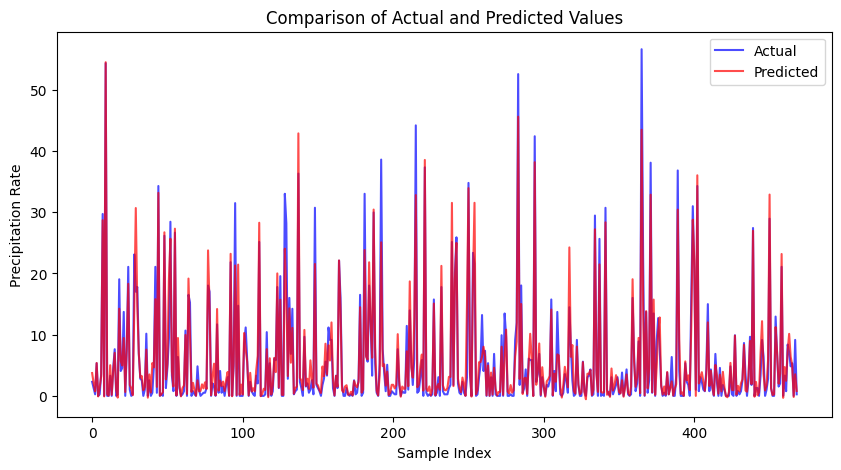

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_tensor.numpy(), label='Actual', color='blue', alpha=0.7)
plt.plot(combined_pred.numpy(), label='Predicted', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Precipitation Rate')
plt.legend()
plt.show()


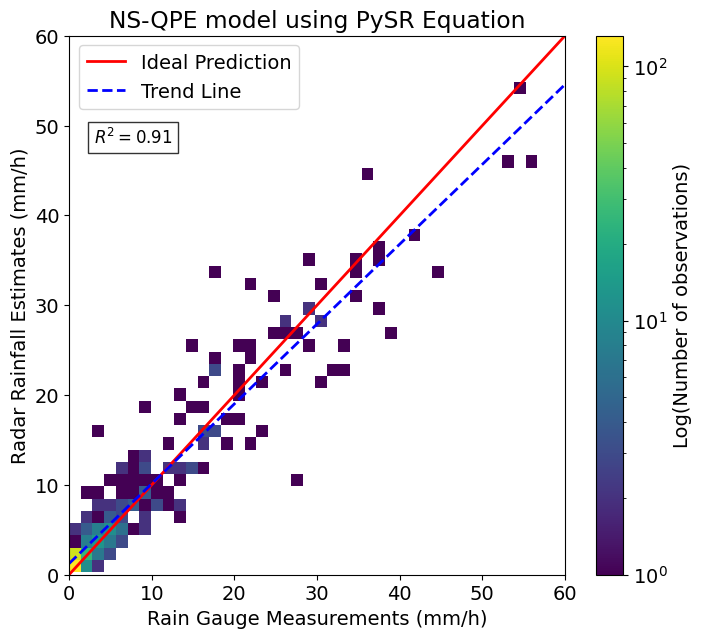

In [ ]:
from matplotlib.colors import LogNorm

# Convert tensors to numpy arrays if they aren't already
actual = y_test_tensor.numpy()
predicted = combined_pred.numpy()


# Create a 2D histogram / heatmap
plt.rcParams.update({'font.size': 14, 'lines.linewidth': 2})

plt.figure(figsize=(8, 7))
h, xedges, yedges, image = plt.hist2d(actual, predicted, bins=40, norm=LogNorm(), cmap='viridis')
plt.colorbar(label='Log(Number of observations)')

# Diagonal line indicating perfect prediction
plt.plot([0, 60], [0, 60], 'r', label='Ideal Prediction')

# Calculate trend line
coefficients = np.polyfit(actual, predicted, 1)  # Linear fit (1st degree polynomial)
trendline = np.poly1d(coefficients)  # Create a polynomial function with these coefficients
x_trend = np.linspace(0, 60, 100)  # Generate x-values for your trendline, adjust range as needed
plt.plot(x_trend, trendline(x_trend), "b--", label='Trend Line')  # Plot trend line

plt.xlabel('Rain Gauge Measurements (mm/h)')
plt.ylabel('Radar Rainfall Estimates (mm/h)')
plt.title('NS-QPE model using PySR Equation')
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.grid(False)
plt.legend()

# Show the R^2 score on the plot
plt.text(3, 48, f'$R^2 = {r2:.2f}$', fontsize=12, bbox=dict(facecolor='white', alpha=0.8), zorder=5)
plt.show()


#SHAP XAI method Analysis


In [ ]:

# Assume symbolic_model and neural_model are your models for symbolic and neural predictions
def combined_model_predict(data):
    # Convert data to tensor if it's not already one (ensure it matches your model input requirements)
    data_tensor = torch.tensor(data, dtype=torch.float32)

    model.eval()  # Set the model to evaluation mode
    # Model predictions
    data_tensor = torch.tensor(data, dtype=torch.float32)

    neural_pred, symbolic_pred = model(data_tensor)

    target = y_train_tensor

    # _, _, _, combined_pred, _, _ = custom_loss_and_combine(neural_pred.squeeze(), symbolic_pred, target, should_print=True)

    #Combined prediction based on the latest weights
    combined_pred = (weights_storage['neural'][-1] * neural_pred.squeeze() + weights_storage['symbolic'][-1] * symbolic_pred)

    return combined_pred.detach().numpy()



In [ ]:
explainer = shap.KernelExplainer(model=combined_model_predict, data=X_train)


In [ ]:
shap_values = explainer.shap_values(X_test)

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
mean_shap_values = np.abs(shap_values).mean(axis=0)
# Define features and a dictionary with fixed colors for each feature
features = ['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']
color_map = {'Reflectivity': '#D62728', 'Zdr': '#FF7F0E', 'Kdp': '#1F77B4', 'Rhohv': '#2CA02C'}  # Fixed colors

# Sort SHAP values and features based on the mean SHAP values
sorted_indices = np.argsort(mean_shap_values)[::-1]
mean_shap_values_sorted = mean_shap_values[sorted_indices]
features_sorted = np.array(features)[sorted_indices]

# Get corresponding fixed colors for each feature
colors_sorted = [color_map[feature] for feature in features_sorted]

# Create a horizontal bar plot with increased bar width for better visibility
plt.barh(features_sorted, mean_shap_values_sorted, color=colors_sorted, edgecolor='black', height=0.6)

# Add SHAP values as text labels on the bars with enhanced visibility
for i, v in enumerate(mean_shap_values_sorted):
    plt.text(v + 0.1, i, f"{v:.2f}", color='black', va='center', fontsize=12, fontweight='bold')

# Add labels and title with larger font sizes
plt.xlabel('Mean |SHAP Value|', fontsize=14, fontweight='bold')
plt.title('Feature Importance Based on SHAP Values', fontsize=16, fontweight='bold')

# Customize tick labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert y-axis to have the highest SHAP values at the top
plt.gca().invert_yaxis()

# Add grid for better readability of SHAP values
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add padding around the plot for better spacing
plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)

# Display the plot
plt.show()

In [ ]:
shap_values.shape

(41, 4)

In [ ]:
# Plot SHAP values for the first test instance
shap.initjs()  # Initialize JavaScript visualization in Jupyter notebook
shap.force_plot(explainer.expected_value, shap_values, filtered_X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
mean_shap_values

array([3.62998576, 0.93235768, 2.06855249, 0.04388405])

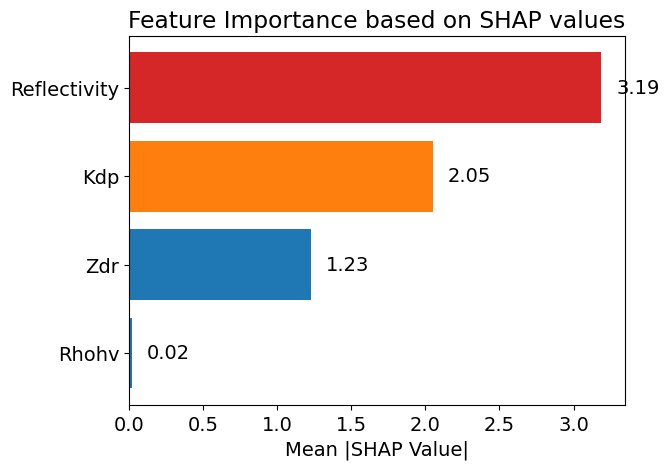

In [ ]:
mean_shap_values = np.abs(shap_values).mean(axis=0)

features = ['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']
colors = ['#D62728', '#FF7F0E', '#1F77B4', '#1F77B4']


sorted_indices = np.argsort(mean_shap_values)[::-1]
mean_shap_values_sorted = mean_shap_values[sorted_indices]
features_sorted = np.array(features)[sorted_indices]
colors_sorted = np.array(colors)[sorted_indices]

# Create a horizontal bar plot
plt.barh(features_sorted, mean_shap_values_sorted, color=colors)

# Add SHAP values as text labels on the bars
for i, v in enumerate(mean_shap_values_sorted):
    plt.text(v + 0.1, i, f"{v:.2f}", color='black', va='center')

# Add labels and title
plt.xlabel('Mean |SHAP Value|')
plt.title('Feature Importance based on SHAP values')

plt.gca().invert_yaxis()

# Display the plot
plt.show()

## Checking SHAP results on Different Conditions


In [ ]:
# Assuming ZDR, KDP, ZH are columns in your X_test DataFrame
ZDR = X_test['Zdr']
KDP = X_test['Kdp']
ZH = X_test['Reflectivity']

# Define conditions
cond1 = (KDP >= 0.3) & (ZH >= 38)
cond2 = (KDP < 0.3)

# Apply the conditions and separate the data
# First subset: cond1 and ZDR >= 0.5
subset1 = X_test[cond1 & (ZDR >= 0.5)]

# Second subset: cond1 and ZDR < 0.5
subset2 = X_test[cond1 & (ZDR < 0.5)]

# Third subset: cond2 and ZDR >= 0.5
subset3 = X_test[cond2 & (ZDR >= 0.5)]

# Fourth subset: cond2 and ZDR < 0.5
subset4 = X_test[cond2 & (ZDR < 0.5)]

In [ ]:
shap_values_1 = explainer.shap_values(subset1)
mean_shap_values = np.abs(shap_values_1).mean(axis=0)

# Define features and a dictionary with fixed colors for each feature
features = ['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']
color_map = {'Reflectivity': '#D62728', 'Zdr': '#FF7F0E', 'Kdp': '#1F77B4', 'Rhohv': '#2CA02C'}  # Fixed colors

# Sort SHAP values and features based on the mean SHAP values
sorted_indices = np.argsort(mean_shap_values)[::-1]
mean_shap_values_sorted = mean_shap_values[sorted_indices]
features_sorted = np.array(features)[sorted_indices]

# Get corresponding fixed colors for each feature
colors_sorted = [color_map[feature] for feature in features_sorted]

# Create a horizontal bar plot with increased bar width for better visibility
plt.barh(features_sorted, mean_shap_values_sorted, color=colors_sorted, edgecolor='black', height=0.6)

# Add SHAP values as text labels on the bars with enhanced visibility
for i, v in enumerate(mean_shap_values_sorted):
    plt.text(v + 0.1, i, f"{v:.2f}", color='black', va='center', fontsize=12, fontweight='bold')

# Add labels and title with larger font sizes
plt.xlabel('Mean |SHAP Value|', fontsize=14, fontweight='bold')
plt.title('Feature Importance Based on SHAP Values', fontsize=16, fontweight='bold')

# Customize tick labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert y-axis to have the highest SHAP values at the top
plt.gca().invert_yaxis()

# Add grid for better readability of SHAP values
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add padding around the plot for better spacing
plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)

# Display the plot
plt.show()


In [ ]:
shap.summary_plot(shap_values_1, subset1)

In [ ]:
shap_values_2 = explainer.shap_values(subset2)
mean_shap_values = np.abs(shap_values_2).mean(axis=0)

# Define features and a dictionary with fixed colors for each feature
features = ['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']
color_map = {'Reflectivity': '#D62728', 'Zdr': '#FF7F0E', 'Kdp': '#1F77B4', 'Rhohv': '#2CA02C'}  # Fixed colors

# Sort SHAP values and features based on the mean SHAP values
sorted_indices = np.argsort(mean_shap_values)[::-1]
mean_shap_values_sorted = mean_shap_values[sorted_indices]
features_sorted = np.array(features)[sorted_indices]

# Get corresponding fixed colors for each feature
colors_sorted = [color_map[feature] for feature in features_sorted]

# Create a horizontal bar plot with increased bar width for better visibility
plt.barh(features_sorted, mean_shap_values_sorted, color=colors_sorted, edgecolor='black', height=0.6)

# Add SHAP values as text labels on the bars with enhanced visibility
for i, v in enumerate(mean_shap_values_sorted):
    plt.text(v + 0.1, i, f"{v:.2f}", color='black', va='center', fontsize=12, fontweight='bold')

# Add labels and title with larger font sizes
plt.xlabel('Mean |SHAP Value|', fontsize=14, fontweight='bold')
plt.title('Feature Importance Based on SHAP Values', fontsize=16, fontweight='bold')

# Customize tick labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert y-axis to have the highest SHAP values at the top
plt.gca().invert_yaxis()

# Add grid for better readability of SHAP values
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add padding around the plot for better spacing
plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)

# Display the plot
plt.show()

In [ ]:
shap.summary_plot(shap_values_2, subset2)

In [ ]:
shap_values_3 = explainer.shap_values(subset3)
mean_shap_values = np.abs(shap_values_3).mean(axis=0)

# Define features and a dictionary with fixed colors for each feature
features = ['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']
color_map = {'Reflectivity': '#D62728', 'Zdr': '#FF7F0E', 'Kdp': '#1F77B4', 'Rhohv': '#2CA02C'}  # Fixed colors

# Sort SHAP values and features based on the mean SHAP values
sorted_indices = np.argsort(mean_shap_values)[::-1]
mean_shap_values_sorted = mean_shap_values[sorted_indices]
features_sorted = np.array(features)[sorted_indices]

# Get corresponding fixed colors for each feature
colors_sorted = [color_map[feature] for feature in features_sorted]

# Create a horizontal bar plot with increased bar width for better visibility
plt.barh(features_sorted, mean_shap_values_sorted, color=colors_sorted, edgecolor='black', height=0.6)

# Add SHAP values as text labels on the bars with enhanced visibility
for i, v in enumerate(mean_shap_values_sorted):
    plt.text(v + 0.1, i, f"{v:.2f}", color='black', va='center', fontsize=12, fontweight='bold')

# Add labels and title with larger font sizes
plt.xlabel('Mean |SHAP Value|', fontsize=14, fontweight='bold')
plt.title('Feature Importance Based on SHAP Values', fontsize=16, fontweight='bold')

# Customize tick labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert y-axis to have the highest SHAP values at the top
plt.gca().invert_yaxis()

# Add grid for better readability of SHAP values
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add padding around the plot for better spacing
plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)

# Display the plot
plt.show()

In [ ]:
shap.summary_plot(shap_values_3, subset3)

In [ ]:
shap_values_4 = explainer.shap_values(subset4)
mean_shap_values = np.abs(shap_values_4).mean(axis=0)
# Define features and a dictionary with fixed colors for each feature
features = ['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']
color_map = {'Reflectivity': '#D62728', 'Zdr': '#FF7F0E', 'Kdp': '#1F77B4', 'Rhohv': '#2CA02C'}  # Fixed colors

# Sort SHAP values and features based on the mean SHAP values
sorted_indices = np.argsort(mean_shap_values)[::-1]
mean_shap_values_sorted = mean_shap_values[sorted_indices]
features_sorted = np.array(features)[sorted_indices]

# Get corresponding fixed colors for each feature
colors_sorted = [color_map[feature] for feature in features_sorted]

# Create a horizontal bar plot with increased bar width for better visibility
plt.barh(features_sorted, mean_shap_values_sorted, color=colors_sorted, edgecolor='black', height=0.6)

# Add SHAP values as text labels on the bars with enhanced visibility
for i, v in enumerate(mean_shap_values_sorted):
    plt.text(v + 0.1, i, f"{v:.2f}", color='black', va='center', fontsize=12, fontweight='bold')

# Add labels and title with larger font sizes
plt.xlabel('Mean |SHAP Value|', fontsize=14, fontweight='bold')
plt.title('Feature Importance Based on SHAP Values', fontsize=16, fontweight='bold')

# Customize tick labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert y-axis to have the highest SHAP values at the top
plt.gca().invert_yaxis()

# Add grid for better readability of SHAP values
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add padding around the plot for better spacing
plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)

# Display the plot
plt.show()

In [ ]:
shap.summary_plot(shap_values_4, subset4)